In [53]:
from keras.utils import image_dataset_from_directory, to_categorical
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

from tensorflow.keras.layers.experimental.preprocessing import Rescaling

import matplotlib.pyplot as plt
import numpy as np
import os
import cv2

Константы

In [55]:
IMAGE_SIZE = (150, 150)
IMAGE_SHAPE = (-1, 150, 150, 1)

In [56]:
train_path = '../dataset/chest_xray/train'
val_path = '../dataset/chest_xray/val'
test_path = '../dataset/chest_xray/test'

In [57]:
labels = ['PNEUMONIA', 'NORMAL']

In [58]:
def check_extensions(dir):
    for label in labels:
        path = os.path.join(dir, label)
        files = os.listdir(path)
        extensions = set()
        for file in files:
            extensions.add(file.split(".")[-1])
        print(extensions)

In [59]:
c = [train_path, val_path, test_path]
for path in c:
    print(path)
    check_extensions(path)

../dataset/chest_xray/train
{'jpeg', 'DS_Store'}
{'jpeg', 'DS_Store'}
../dataset/chest_xray/val
{'jpeg', 'DS_Store'}
{'jpeg', 'DS_Store'}
../dataset/chest_xray/test
{'jpeg'}
{'jpeg'}


In [60]:
def get_training_data(data_dir: str):
    image_array = []
    classes = []
    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            if ".jpeg" not in img:
                continue
            image = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
            resized_img = cv2.resize(image, IMAGE_SIZE)
            image_array.append(resized_img)
            classes.append(class_num)
    return np.array(image_array), np.array(classes)

In [61]:
x_train, y_train = get_training_data(train_path)
x_test, y_test = get_training_data(test_path)
x_val, y_val = get_training_data(val_path)

Функции визуализации

In [62]:
def pie_plot(data: list, labels: list, title: str):
    plt.pie(data, labels=labels)
    plt.title(title)
    plt.show()

In [63]:
def score_plot(data: list, labels: list, title: str, color: list):
    plt.bar(labels, data, color=color)
    plt.title(title)
    plt.show()

In [64]:
pneumo = 0
norm = 0
for i in y_train:
    if(i == 0):
        pneumo += 1
    else:
        norm += 1

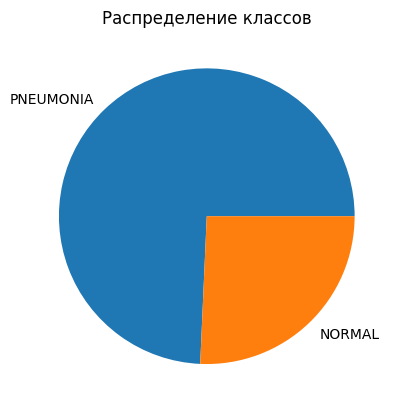

In [65]:
pie_plot((pneumo, norm), labels=labels, title="Распределение классов")

Нормализация датасета

In [66]:
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255
x_test = np.array(x_test) / 255

In [67]:
x_train = x_train.reshape(IMAGE_SHAPE)
x_val = x_val.reshape(IMAGE_SHAPE)
x_test = x_test.reshape(IMAGE_SHAPE)

Аугментация

In [68]:
datagen = ImageDataGenerator(
        featurewise_center=False,
        samplewise_center=False,
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False,
        rotation_range = 30,
        zoom_range = 0.2,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip = True,
        vertical_flip=False)

In [69]:
datagen.fit(x_train)

Создание модели

In [70]:
model = Sequential([
    Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (150,150,1)),
    BatchNormalization(),
    MaxPool2D((2,2) , strides = 2 , padding = 'same'),
    Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'),
    Dropout(0.1),
    BatchNormalization(),
    MaxPool2D((2,2) , strides = 2 , padding = 'same'),
    Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'),
    BatchNormalization(),
    MaxPool2D((2,2) , strides = 2 , padding = 'same'),
    Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'),
    Dropout(0.2),
    BatchNormalization(),
    MaxPool2D((2,2) , strides = 2 , padding = 'same'),
    Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'),
    Dropout(0.2),
    BatchNormalization(),
    MaxPool2D((2,2) , strides = 2 , padding = 'same'),
    Flatten(),
    Dense(units = 128 , activation = 'relu'),
    Dropout(0.2),
    Dense(units = 1 , activation = 'sigmoid'),
])

Компиляция модели

In [71]:
model.compile(optimizer = "rmsprop" , loss = 'binary_crossentropy' , metrics = ['accuracy'])

Корректировка скорости обучения

In [72]:
lr = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=True, factor=0.3, min_lr=0.000001)

In [73]:
history = model.fit(datagen.flow(x_train,y_train, batch_size = 32), epochs = 12 , validation_data = datagen.flow(x_val, y_val), callbacks = [lr])

Epoch 1/12
163/163 [==============================] - 338s 2s/step - loss: 0.6901 - accuracy: 0.8261 - val_loss: 69.6647 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 2/12
163/163 [==============================] - 325s 2s/step - loss: 0.2812 - accuracy: 0.8865 - val_loss: 86.7975 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 3/12
163/163 [==============================] - ETA: 0s - loss: 0.2164 - accuracy: 0.9193
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
163/163 [==============================] - 330s 2s/step - loss: 0.2164 - accuracy: 0.9193 - val_loss: 19.6088 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 4/12
163/163 [==============================] - 353s 2s/step - loss: 0.1600 - accuracy: 0.9471 - val_loss: 0.8887 - val_accuracy: 0.6875 - lr: 3.0000e-04
Epoch 5/12
163/163 [==============================] - 337s 2s/step - loss: 0.1362 - accuracy: 0.9503 - val_loss: 2.6197 - val_accuracy: 0.5000 - lr: 3.0000e-04
Epoch 6/12
163/163 [============================

In [74]:
train_acc = model.evaluate(x_train,y_train)[1]
test_acc = model.evaluate(x_test,y_test)[1]

20/20 [==============================] - 9s 435ms/step - loss: 0.2637 - accuracy: 0.9006


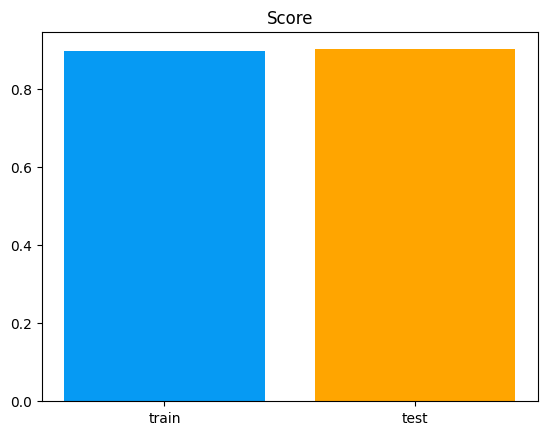

In [75]:
score_plot((train_acc, test_acc), ('train', 'test'), title="Score", color=('#069AF3', 'orange'))

Сохранение модели

In [78]:
test_score = int(round(test_acc, 2) * 100)

model.save(f"../models/cnn{test_score}.h5")